In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) 

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [ ]:
train_data_dir = '/content/drive/MyDrive/images/test'
test_data_dir = '/content/drive/MyDrive/images/train'


traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1221 images belonging to 3 classes.
Found 214 images belonging to 3 classes.
Found 5752 images belonging to 3 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    conv_base = VGG19(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    model = Model(inputs=conv_base.input, outputs=output_layer)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 20

vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

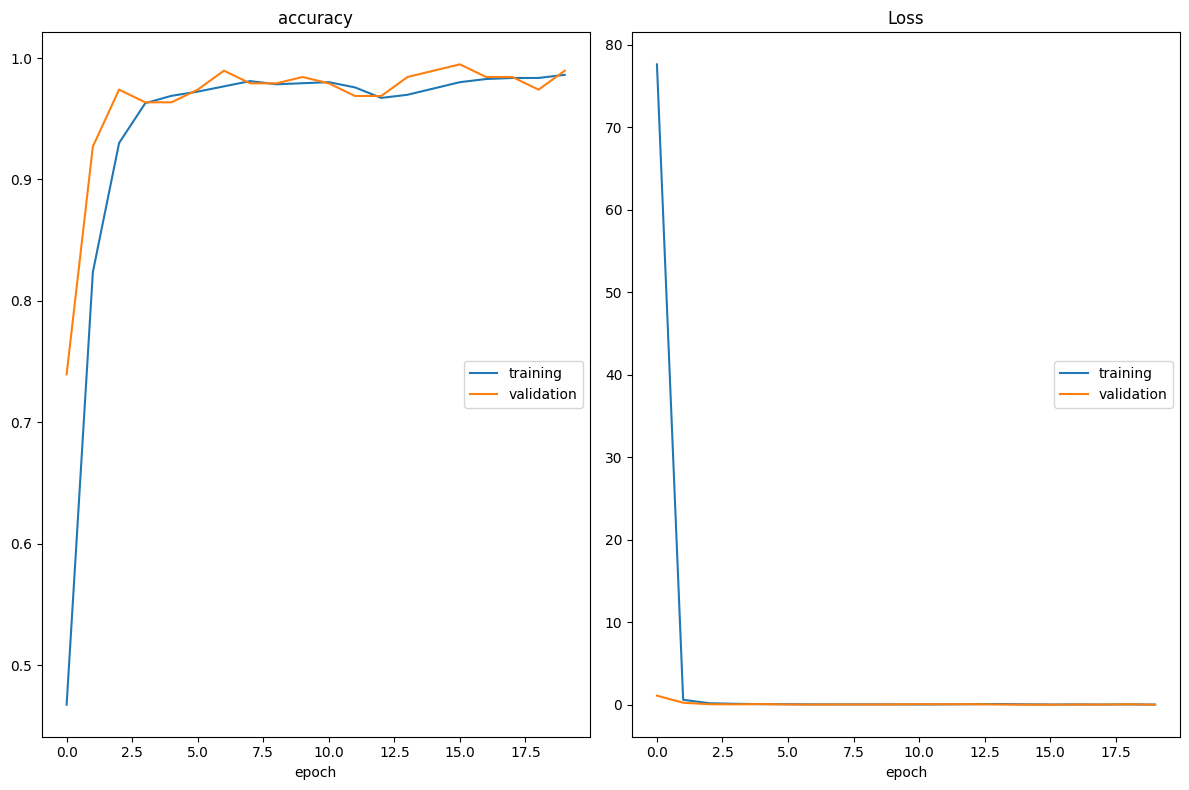

accuracy
	training         	 (min:    0.468, max:    0.986, cur:    0.986)
	validation       	 (min:    0.740, max:    0.995, cur:    0.990)
Loss
	training         	 (min:    0.040, max:   77.598, cur:    0.040)
	validation       	 (min:    0.023, max:    1.118, cur:    0.025)
19/19 [==============================] - 954s 50s/step - loss: 0.0400 - accuracy: 0.9862 - val_loss: 0.0252 - val_accuracy: 0.9896
CPU times: user 8h 42min 25s, sys: 22min 57s, total: 9h 5min 22s
Wall time: 5h 32min 14s


In [ ]:

%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:

vgg_model.load_weights('tl_model_v1.weights.best.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

5752/5752 [==============================] - 4153s 722ms/step


In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print(vgg_acc)
print("--------------------------------------------")
print(precision_recall_fscore_support(true_classes, vgg_pred_classes))

0.9278511821974965
--------------------------------------------
(array([0.88405797, 0.97348485, 0.93129771]), array([0.94039054, 0.90950455, 0.93435449]), array([0.91135458, 0.94040774, 0.93282359]), array([1946, 1978, 1828]))


In [ ]:
vgg_model.save('vgg19.h5')